### Gather required libraries

Optimal formation rates by product:
Product 1: k_formation = 0.023763
Product 2: k_formation = 0.000000
Product 3: k_formation = 0.000000

Optimal trimming rates:
Product 1 to Product 2: k_trimming = 0.010809
Product 1 to Product 3: k_trimming = 0.006370
Product 2 to Product 3: k_trimming = 0.000012

R-squared values by product:
Substrate: R-squared = 0.869899
Product 1: R-squared = 0.630499
Product 2: R-squared = 0.793183
Product 3: R-squared = 0.807645

Sum of Squared Residuals (SSR) by product:
Substrate: SSR = 0.114056
Product 1: SSR = 0.071406
Product 2: SSR = 0.065069
Product 3: SSR = 0.030259


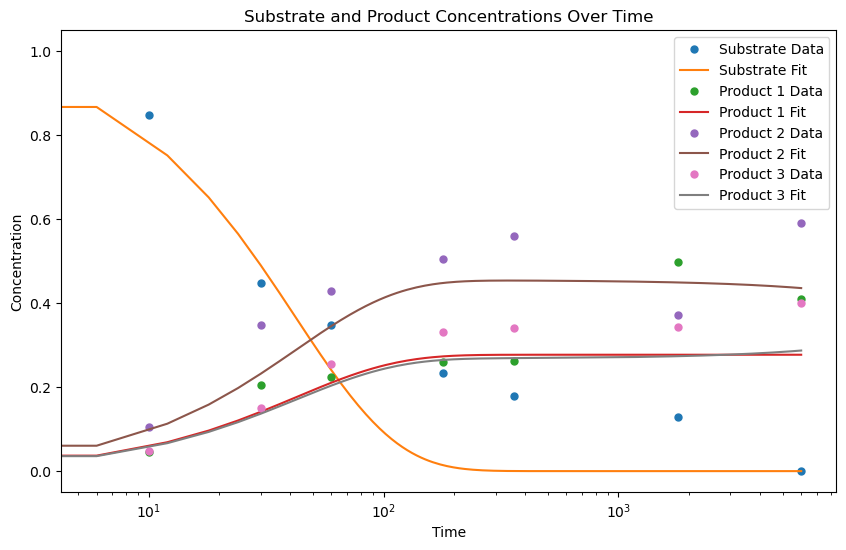

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Example data for 3 products (can be modified for more or fewer products)
time_data = [0, 10, 30, 60, 180, 360, 1800, 6000]  # Time points
substrate_data = [1, 0.849, 0.447, 0.349, 0.234, 0.178, 0.129, 0]  # Substrate concentration over time
product_data = [
    [0, 0.046, 0.205, 0.223, 0.259, 0.263, 0.499, 0.409],  # Product 1
    [0, 0.104, 0.348, 0.428, 0.506, 0.56, 0.372, 0.591],   # Product 2
    [0, 0.048, 0.151, 0.255, 0.331, 0.341, 0.343, 0.401]   # Product 3
]

# Filter out products with all zero values
filtered_product_data = [pd for pd in product_data if not all(v == 0 for v in pd)]
n_products = len(filtered_product_data)

# ODE system definition
def ode_system(t, y, params, n_products):
    S = y[0]
    dSdt = 0
    dPdt = [0] * n_products

    # Split params into formation and trimming rates
    k_formation = params[:n_products]
    k_trimming = params[n_products:]

    # Substrate depletion
    dSdt = -np.sum([k_formation[i] * S for i in range(n_products)])

    # Product formation directly from substrate
    for i in range(n_products):
        dPdt[i] += k_formation[i] * S
    
    # Product trimming between products
    k_trimming_index = 0
    for i in range(n_products):
        for j in range(i+1, n_products):
            dPdt[j] += k_trimming[k_trimming_index] * y[i]  # Trimming from Product i to Product j
            dPdt[i] -= k_trimming[k_trimming_index] * y[i]  # Reduction in Product i due to trimming
            k_trimming_index += 1

    return [dSdt] + dPdt

# Fitting function
def fitting_function(params, n_products, substrate_data, product_data):
    y0 = [substrate_data[0]] + [pd[0] for pd in product_data]
    sol = solve_ivp(
        lambda t, y: ode_system(t, y, params, n_products),
        [time_data[0], time_data[-1]],
        y0,
        t_eval=time_data,
        method='LSODA'
    )
    y_predicted = sol.y
    residuals = [y_predicted[0] - substrate_data]
    for i in range(n_products):
        residuals.append(y_predicted[i + 1] - product_data[i])
    return np.concatenate(residuals)

# Function to calculate R-squared
def r_squared(y_true, y_pred):
    mean_y = np.mean(y_true)
    ss_total = np.sum((y_true - mean_y)**2)
    ss_residual = np.sum((y_true - y_pred)**2)
    return 1 - (ss_residual / ss_total)

# Function to calculate Sum of Squared Residuals (SSR)
def sum_squared_residuals(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

# Initial guess for parameters
n_trimming_params = (n_products * (n_products - 1)) // 2
initial_guess = [0.1] * n_products + [0.1] * n_trimming_params  # Example initial guess for the parameters

# Fit the fitting function to the data using least squares
bounds = (0, np.inf)  # Bounds to ensure non-negative parameters
result = least_squares(
    fitting_function, 
    initial_guess, 
    bounds=bounds, 
    args=(n_products, substrate_data, filtered_product_data)
)

# Extract the optimal parameters
optimal_params = result.x
k_formation_opt = optimal_params[:n_products]
k_trimming_opt = optimal_params[n_products:]

# Print the optimal parameters by product
print("Optimal formation rates by product:")
for i in range(n_products):
    print(f"Product {i + 1}: k_formation = {k_formation_opt[i]:.6f}")

print("\nOptimal trimming rates:")
k_trimming_index = 0
for i in range(n_products):
    for j in range(i + 1, n_products):
        print(f"Product {i + 1} to Product {j + 1}: k_trimming = {k_trimming_opt[k_trimming_index]:.6f}")
        k_trimming_index += 1

# Evaluate the fit quality
y0 = [substrate_data[0]] + [pd[0] for pd in filtered_product_data]
sol = solve_ivp(
    lambda t, y: ode_system(t, y, optimal_params, n_products),
    [time_data[0], time_data[-1]],
    y0,
    t_eval=time_data,
    method='LSODA'
)
y_predicted = sol.y

print("\nR-squared values by product:")
r2_substrate = r_squared(substrate_data, y_predicted[0])
print(f"Substrate: R-squared = {r2_substrate:.6f}")
for i in range(n_products):
    r2_product = r_squared(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: R-squared = {r2_product:.6f}")

print("\nSum of Squared Residuals (SSR) by product:")
ssr_substrate = sum_squared_residuals(substrate_data, y_predicted[0])
print(f"Substrate: SSR = {ssr_substrate:.6f}")
for i in range(n_products):
    ssr_product = sum_squared_residuals(filtered_product_data[i], y_predicted[i + 1])
    print(f"Product {i + 1}: SSR = {ssr_product:.6f}")

# Time values for plotting
x_values = np.linspace(0, 6000, 1000)
sol_plot = solve_ivp(
    lambda t, y: ode_system(t, y, optimal_params, n_products),
    [x_values[0], x_values[-1]],
    y0,
    t_eval=x_values,
    method='LSODA'
)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(time_data, substrate_data, 'o', label='Substrate Data', markersize=5)
plt.plot(x_values, sol_plot.y[0], '-', label='Substrate Fit')

for i in range(n_products):
    plt.plot(time_data, filtered_product_data[i], 'o', label=f'Product {i + 1} Data', markersize=5)
    plt.plot(x_values, sol_plot.y[i + 1], '-', label=f'Product {i + 1} Fit')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Substrate and Product Concentrations Over Time')
plt.xscale('log')
plt.legend()
plt.show()
